# Employee Retention

We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.

As said above, the goal is to predict employee retention and understand its main drivers. Specifically, you should:

Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id.
What are the main factors that drive employee churn? Do they make sense? Explain your findings.
If you could add to this data set just one variable that could help explain employee churn, what would that be?

The table is: employee_retention - comprehensive information about employees. Columns:

employee_id : id of the employee. Unique by employee per company
company_id : company id.
dept : employee dept
seniority : number of yrs of work experience when hired
salary: avg yearly salary of the employee during her tenure within the company
join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13
quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

In [2]:
import pandas as pd
from pandas.io import sql
import sqlite3
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import tree
%matplotlib inline

In [3]:
df = pd.read_csv('employee_retention/employee_retention_data.csv')
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [5]:

conn = sqlite3.connect('employee.db')
conn.text_factory = str
cur = conn.cursor()
cur.execute('CREATE TABLE data (employee_id INTEGER, company_id INTEGER, dept TEXT, seniority INTEGER, salary INTEGER, join_date TEXT, quit_date TEXT);')

In [6]:
with open('employee_retention/employee_retention_data.csv','r') as fname:
    dr = csv.DictReader(fname)
    to_db = [(i['employee_id'],i['company_id'], i['dept'], i['seniority'], i['salary'], i['join_date'], i['quit_date']) for i in dr]

cur.executemany("INSERT INTO data (employee_id, company_id, dept, seniority, salary, join_date, quit_date) VALUES (?, ?, ?, ?, ?, ?, ?);", to_db)
# To insert multiple rows in the table "data" from csv file

conn.commit()

In [7]:

conn = sqlite3.connect('employee.db')
c = conn.cursor()
c.execute("SELECT employee_id FROM data").fetchall()

[(13021,),
 (825355,),
 (927315,),
 (662910,),
 (256971,),
 (509529,),
 (88600,),
 (716309,),
 (172999,),
 (504159,),
 (892155,),
 (904158,),
 (939058,),
 (163427,),
 (461248,),
 (265226,),
 (932790,),
 (69693,),
 (721600,),
 (982668,),
 (123896,),
 (219944,),
 (569302,),
 (189981,),
 (819445,),
 (467023,),
 (6808,),
 (940786,),
 (888375,),
 (564835,),
 (72260,),
 (476097,),
 (922883,),
 (29950,),
 (298691,),
 (361378,),
 (958767,),
 (942845,),
 (573299,),
 (739669,),
 (390806,),
 (489148,),
 (991265,),
 (13380,),
 (16871,),
 (537932,),
 (282949,),
 (139022,),
 (945037,),
 (695896,),
 (280427,),
 (611637,),
 (437897,),
 (960822,),
 (789114,),
 (87671,),
 (75539,),
 (244626,),
 (957742,),
 (268784,),
 (701728,),
 (54096,),
 (41164,),
 (779068,),
 (503937,),
 (47442,),
 (928528,),
 (263170,),
 (707610,),
 (864762,),
 (428183,),
 (727560,),
 (641843,),
 (752719,),
 (970566,),
 (611675,),
 (176568,),
 (507843,),
 (895072,),
 (678783,),
 (660969,),
 (539604,),
 (244440,),
 (511426,),
 (5858

In [8]:

df2 = sql.read_sql('select * from data', conn)
df2.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021,7,customer_service,28,89000,2014-03-24,2015-10-30
1,825355,7,marketing,20,183000,2013-04-29,2014-04-04
2,927315,4,marketing,14,101000,2014-10-13,NA
3,662910,7,customer_service,20,115000,2012-05-14,2013-06-07
4,256971,2,data_science,23,276000,2011-10-17,2014-08-22


## Create table of company, date, employee head count

In [9]:

dates = pd.date_range(start='2011/01/24',end='2015/12/13')
temp = {'date':dates}
temp = pd.DataFrame(data=temp)
temp['key']=0

In [10]:

unique_companies = df.company_id.unique()
temp1 = {'company_id':unique_companies}
temp1 = pd.DataFrame(data=temp1)
temp1['key']=0

In [11]:
merged = pd.merge(temp, temp1,on='key')
merged.drop('key',1, inplace=True)

In [12]:
merged.head()

,date,company_id
0,2011-01-24,7
1,2011-01-24,4
2,2011-01-24,2
3,2011-01-24,9
4,2011-01-24,1


In [13]:

join_by_day = df.groupby(['company_id','join_date'])['company_id','join_date'].sum()
join_by_day.head()

company_id
company_id join_date             
1          2011-01-24          25
           2011-01-25           2
           2011-01-26           2
           2011-01-31          30
           2011-02-01           7

In [14]:
join_by_day.columns = ['number']  #number: dummy variable
join_by_day.reset_index(inplace=True)
join_by_day.columns = ['company_id','date','number_join']
join_by_day['date'] = pd.to_datetime(join_by_day['date'])
join_by_day.head()

,company_id,date,number_join
0,1,2011-01-24,25
1,1,2011-01-25,2
2,1,2011-01-26,2
3,1,2011-01-31,30
4,1,2011-02-01,7


In [15]:
quit_by_day = df.groupby(['company_id','quit_date'])[['company_id','quit_date']].sum()
quit_by_day.columns = ['number']
quit_by_day.reset_index(inplace=True)
quit_by_day.columns = ['company_id','date','number_quit']
quit_by_day['date'] = pd.to_datetime(quit_by_day['date'])
quit_by_day.head()

,company_id,date,number_quit
0,1,2011-10-21,1
1,1,2011-11-11,1
2,1,2011-11-22,1
3,1,2011-11-25,1
4,1,2011-12-09,1


In [16]:
test=pd.merge(merged,quit_by_day,left_on=['company_id','date'],right_on=['company_id','date'],how='left').fillna(0)
sum(test['number_quit'])

46738.0

In [17]:

test2=pd.merge(test,join_by_day,left_on=['company_id','date'],right_on=['company_id','date'],how='left').fillna(0)
test2

,date,company_id,number_quit,number_join
0,2011-01-24,7,0.0,7.0
1,2011-01-24,4,0.0,48.0
2,2011-01-24,2,0.0,34.0
3,2011-01-24,9,0.0,27.0
4,2011-01-24,1,0.0,25.0
5,2011-01-24,6,0.0,18.0
6,2011-01-24,10,0.0,0.0
7,2011-01-24,5,0.0,25.0
8,2011-01-24,3,0.0,27.0
9,2011-01-24,8,0.0,48.0


In [18]:
test2['employee_count'] = test2['number_join']-test2['number_quit']
test2

,date,company_id,number_quit,number_join,employee_count
0,2011-01-24,7,0.0,7.0,7.0
1,2011-01-24,4,0.0,48.0,48.0
2,2011-01-24,2,0.0,34.0,34.0
3,2011-01-24,9,0.0,27.0,27.0
4,2011-01-24,1,0.0,25.0,25.0
5,2011-01-24,6,0.0,18.0,18.0
6,2011-01-24,10,0.0,0.0,0.0
7,2011-01-24,5,0.0,25.0,25.0
8,2011-01-24,3,0.0,27.0,27.0
9,2011-01-24,8,0.0,48.0,48.0


In [19]:
test2.drop(['number_quit','number_join'],1, inplace=True)
test2

,date,company_id,employee_count
0,2011-01-24,7,7.0
1,2011-01-24,4,48.0
2,2011-01-24,2,34.0
3,2011-01-24,9,27.0
4,2011-01-24,1,25.0
5,2011-01-24,6,18.0
6,2011-01-24,10,0.0
7,2011-01-24,5,25.0
8,2011-01-24,3,27.0
9,2011-01-24,8,48.0


In [20]:
employee_count_table=test2.groupby(['date','company_id']).sum().groupby(['company_id']).cumsum()
employee_count_table.reset_index(inplace=True)
employee_count_table.head()

,date,company_id,employee_count
0,2011-01-24,1,25.0
1,2011-01-24,2,34.0
2,2011-01-24,3,27.0
3,2011-01-24,4,48.0
4,2011-01-24,5,25.0


## Distributions of length of employment and weeks of year when employees quit

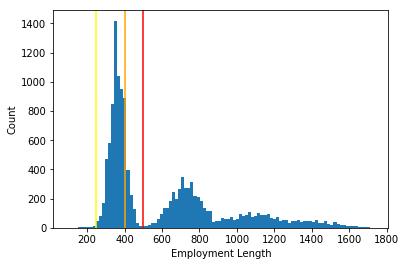

In [21]:
length=pd.to_datetime(df['quit_date'])-pd.to_datetime(df['join_date'])
length1=length.apply(lambda x:float(x.days)) # employment length in days on x axis 
#change value for unavailable date (joining or quit date) of employee from NaT to NaN
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Employment Length')
ax.set_ylabel('Count')
ax.hist(length1[np.isfinite(length1)],bins=100)  # use only valid values for histogram
ax.axvline(x=500,color='red')  # lines are drawn to identify drop in employee count
ax.axvline(x=400,color='orange') # lines are drawn to identify drop in employee count
ax.axvline(x=250,color='yellow') # lines are drawn to identify drop in employee count
plt.show()


In [22]:
week_of_year = pd.to_datetime(df['quit_date'])
week_of_year

0       2015-10-30
1       2014-04-04
2              NaT
3       2013-06-07
4       2014-08-22
5       2013-08-30
6              NaT
7              NaT
8       2015-10-23
9              NaT
10      2015-02-27
11             NaT
12      2013-11-15
13      2015-09-25
14      2014-08-22
15      2015-07-10
16      2013-11-22
17             NaT
18             NaT
19             NaT
20             NaT
21      2013-05-31
22      2015-07-06
23      2014-08-15
24      2014-08-01
25      2013-02-08
26             NaT
27      2012-03-02
28      2013-10-04
29      2014-04-11
           ...    
24672   2014-07-07
24673   2015-02-27
24674   2015-06-26
24675   2015-07-10
24676   2013-03-08
24677   2013-05-10
24678   2013-04-19
24679          NaT
24680          NaT
24681          NaT
24682          NaT
24683          NaT
24684   2013-04-19
24685   2015-06-05
24686   2014-04-21
24687   2015-07-10
24688          NaT
24689   2013-08-09
24690   2015-01-23
24691          NaT
24692   2013-04-26
24693       

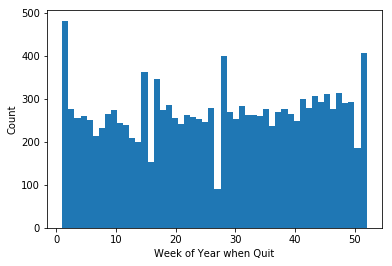

In [23]:
week_of_year = week_of_year.apply(lambda x:float(x.week))  # employment length in number of weeks
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Week of Year when Quit')
ax.set_ylabel('Count')
ax.hist(week_of_year[np.isfinite(week_of_year)],bins=50)   # use only valid values for histogram
plt.show()

## Add the employment length to the dataframe.

In [24]:
df['length'] = length1
df['length']=df['length'].fillna(-1)  # for employement length of NaN, fill -1 in original dataframe
df

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,-1.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578.0
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaN,-1.0
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaN,-1.0
8,172999.0,9,engineer,7,160000.0,2012-12-10,2015-10-23,1047.0
9,504159.0,1,sales,7,104000.0,2012-06-12,NaN,-1.0


In [25]:
df['week_of_year'] = week_of_year
df['week_of_year']=df['week_of_year'].fillna(-1)
df

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length,week_of_year
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,44.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,14.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,-1.0,-1.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,23.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,34.0
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578.0,35.0
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaN,-1.0,-1.0
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaN,-1.0,-1.0
8,172999.0,9,engineer,7,160000.0,2012-12-10,2015-10-23,1047.0,43.0
9,504159.0,1,sales,7,104000.0,2012-06-12,NaN,-1.0,-1.0


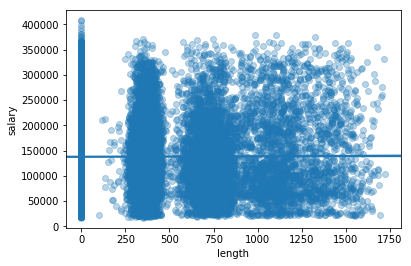

In [26]:
ax2 = sns.regplot(x="length", y="salary", data=df, scatter_kws={'alpha':0.3})

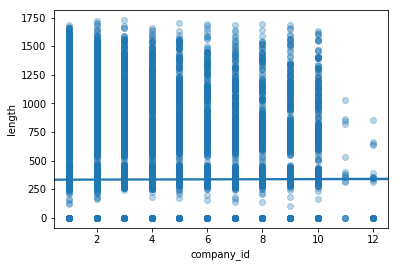

In [27]:
ax2 = sns.regplot(x="company_id", y="length", data=df, scatter_kws={'alpha':0.3})

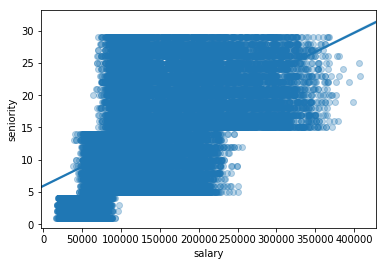

In [28]:
ax2 = sns.regplot(x="salary", y="seniority", data=df[df['seniority']<40], scatter_kws={'alpha':0.3})

In [29]:
df_dept = pd.get_dummies(df['dept'])
df = pd.concat([df, df_dept], axis=1) # add all departments as columns in dataset and for every employee, his dept is selected
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length,week_of_year,customer_service,data_science,design,engineer,marketing,sales
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,44.0,1,0,0,0,0,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,14.0,0,0,0,0,1,0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,-1.0,-1.0,0,0,0,0,1,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,23.0,1,0,0,0,0,0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,34.0,0,1,0,0,0,0


## Use ML model: Decision tree to predict about employees who quit early and why ?

In [30]:
def is_employed(row):
    if row['length'] < 396 and row['quit_date'] == row['quit_date']:
        val = 1
    else:
        val = 0
    return val
df['employed'] = df.apply(is_employed,axis=1)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length,week_of_year,customer_service,data_science,design,engineer,marketing,sales,employed
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,44.0,1,0,0,0,0,0,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,14.0,0,0,0,0,1,0,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,-1.0,-1.0,0,0,0,0,1,0,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,23.0,1,0,0,0,0,0,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,34.0,0,1,0,0,0,0,0


In [39]:
df_for_tree = df[pd.to_datetime(df['join_date'])<pd.to_datetime('2015-12-13')-pd.to_timedelta(396,unit='d')]
#pd.to_timedelta will produce 396 days as output
# find employees before "2015-12-13" from dataframe and substract "396" days so that new joining data could 
# pd.to_datetime('2015-12-13')-pd.to_timedelta(396,unit='d') will return Timestamp('2014-11-12 00:00:00').
# SO here we are trying to find employees whose joining data is before this date i.e 2011, 2012, 2013, 2014.\


In [55]:
X=df_for_tree[['week_of_year','company_id','customer_service','data_science','design','engineer','marketing','sales','seniority','salary']]
y=df_for_tree['employed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

In [56]:
clf = tree.DecisionTreeClassifier()

clf = clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

In [58]:
accuracy_score(predicted, y_test)  # if "week of year" would be removed, accuracy drops to 0.597

0.6526729559748428

In [59]:
clf.feature_importances_
# clearly shows that "week of year" as most important feature followed by "salary"

array([0.37375194, 0.12028678, 0.00434176, 0.00983611, 0.00828506,
       0.01110001, 0.01304664, 0.01515002, 0.1692494 , 0.27495231])

In [64]:
df['salary_percent'] = pd.qcut(df['salary'], 50, labels=False)  
#split "salary" data in 50 bins or quantiles such that entire "salary" is divided into 50 bands
df

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,length,week_of_year,customer_service,data_science,design,engineer,marketing,sales,employed,salary_percent
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,44.0,1,0,0,0,0,0,0,14
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,14.0,0,0,0,0,1,0,1,36
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,-1.0,-1.0,0,0,0,0,1,0,0,18
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,23.0,1,0,0,0,0,0,1,22
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,34.0,0,1,0,0,0,0,0,46
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578.0,35.0,0,1,0,0,0,0,0,33
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaN,-1.0,-1.0,1,0,0,0,0,0,0,20
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaN,-1.0,-1.0,1,0,0,0,0,0,0,1
8,172999.0,9,engineer,7,160000.0,2012-12-10,2015-10-23,1047.0,43.0,0,0,0,1,0,0,0,32
9,504159.0,1,sales,7,104000.0,2012-06-12,NaN,-1.0,-1.0,0,0,0,0,0,1,0,19


In [65]:

df.groupby(['salary_percent'])['employed'].sum()  #number of working employees in salary band

salary_percent
0     102
1      97
2     103
3      97
4      89
5     115
6     105
7     119
8     115
9     100
10     92
11    145
12    112
13    122
14    129
15    111
16    157
17    107
18    105
19    135
20    161
21    122
22    120
23    126
24    137
25    101
26    176
27    146
28    154
29    117
30    161
31    136
32    112
33    151
34    104
35    137
36    116
37    126
38    112
39    103
40    126
41    117
42    108
43     83
44     96
45     74
46     70
47     65
48     55
49     46
Name: employed, dtype: int64

In [66]:
# We are trying to identify that hwo many total employees were available in specific salary quantile
# and out of total employees, how many of employees are currently working. This will help us understand 
# what percentage of employes who have specific "salary_percent" left us, which can help us find whether
# salary plays role in employee attrition (since "salary" is second important feature after "week of year")

percentiles = df.groupby('salary_percent')['employed'].agg(['sum','count']) 
#sum will get currently working employees and count will calculate total working employees
percentiles['percent'] = percentiles['sum']/percentiles['count']
percentiles.head()  #

,sum,count,percent
salary_percent,,,
0,102,531,0.192090
1,97,500,0.194000
2,103,462,0.222944
3,97,506,0.191700
4,89,473,0.188161


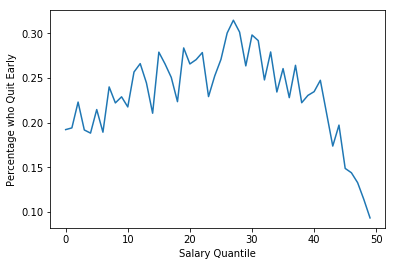

In [67]:

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(percentiles.index,percentiles['percent'])
ax3.set_xlabel('Salary Quantile')
ax3.set_ylabel('Percentage who Quit Early')
plt.show()